In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

---

General variables and dictionaries

In [2]:
VARIABLE = 'MonthlyIncome'
VARIABLE2 = 'Monthly income'

PREDICTOR = 'YearsOfEducation'
PREDICTOR2 = 'Years of education'

ALPHA_LEVEL = 0.05

J = 6 # Number of regions

In [3]:
RegionsToNumbers = {
    'NorthernThailand': 0
    , 'SouthernThailand': 2
    , 'WesternThailand': 3
    , 'EasternThailand': 5
    , 'NortheastThailand': 1
    , 'CentralThailand': 4
}

In [4]:
NumbersToRegions = {
    0: 'Northern Thailand'
    , 2: 'Southern Thailand'
    , 3: 'Western Thailand'
    , 5: 'Eastern Thailand'
    , 1: 'Northeast Thailand'
    , 4: 'Central Thailand'
}

---

Read the data and give it the basic needed structure

In [5]:
ProvincesProvinceIdRegion = pd.read_csv("../../../Data/Enriched/ProvincesProvinceIdRegion.csv")

In [6]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
Dat = pd.merge(Dat, ProvincesProvinceIdRegion)
Dat['RegionNumber'] = Dat['Region'].replace(RegionsToNumbers)

In [7]:
Dat = Dat[[VARIABLE + 'Mean', PREDICTOR, 'RegionNumber']]

---

Calculate the statistics per region

In [8]:
DatRegion = Dat[[PREDICTOR, VARIABLE + 'Mean', 'RegionNumber']].groupby(['RegionNumber']).mean().reset_index()
DatRegion = DatRegion.rename(columns={PREDICTOR: PREDICTOR + 'Region'})

Dat = pd.merge(Dat, DatRegion[[PREDICTOR + 'Region', 'RegionNumber']], on='RegionNumber')

---

Regression model with separate $\alpha$'s and $\beta$'s

In [9]:
with pm.Model() as ModelSeparateAlphaSeparateBeta:
    Alpha = pm.Flat('Alpha', shape=J)
    Beta  = pm.Flat('Beta', shape=J)

    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['RegionNumber']] + Beta[Dat['RegionNumber']] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma[Dat['RegionNumber']], observed=Dat[VARIABLE + 'Mean'])

Get a sample from the posterior and the posterior predictive

In [10]:
with ModelSeparateAlphaSeparateBeta:
    TraceSeparateAlphaSeparateBeta = pm.sample()
    TraceSeparateAlphaSeparateBeta.extend(pm.sample_posterior_predictive(TraceSeparateAlphaSeparateBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
Sampling: [Income]


---

Regional average income, ratio of income per year-of-education

In [11]:
DatRegion['Region'] = DatRegion['RegionNumber'].replace(NumbersToRegions)

In [12]:
PosteriorAlpha = az.summary(
    TraceSeparateAlphaSeparateBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'Alpha'
)

PosteriorAlpha = PosteriorAlpha.rename(
    columns = {
        'mean': 'HatAlpha'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100) + '%': 'LowAlpha'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100) + '%': 'UppAlpha'
    }
)

In [13]:
PosteriorBeta = az.summary(
    TraceSeparateAlphaSeparateBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'Beta'
)

PosteriorBeta = PosteriorBeta.rename(
    columns = {
        'mean': 'HatBeta'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100) + '%': 'LowBeta'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100) + '%': 'UppBeta'
    }
)

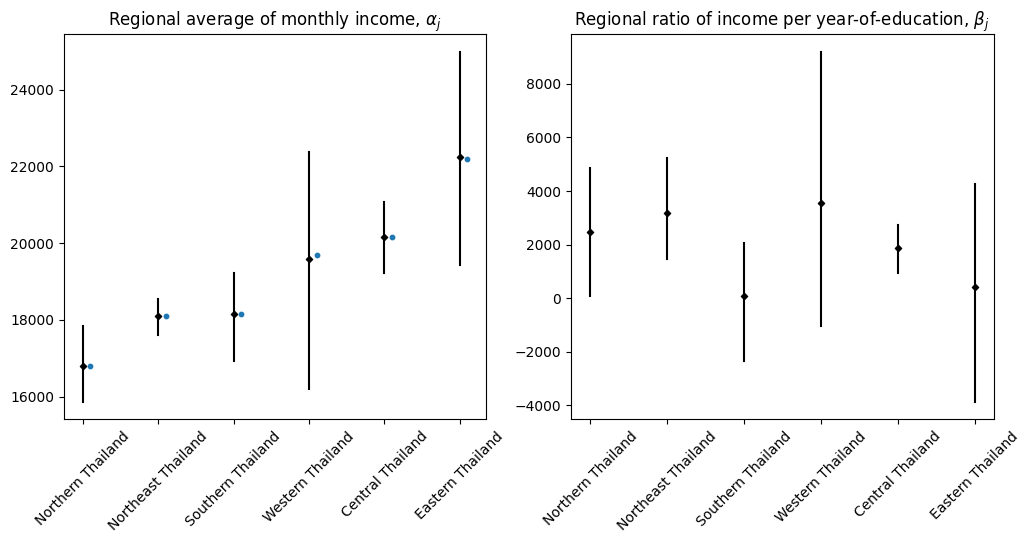

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for k, ax in enumerate(axs.reshape(-1)):
    if k == 0:
        ax.scatter(range(J), PosteriorAlpha['HatAlpha'], marker='D', color='k', s=10)
        ax.scatter(np.arange(0.1, J+0.1, 1), DatRegion[VARIABLE + 'Mean'], marker='o', color='C0', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorAlpha['LowAlpha'][j], PosteriorAlpha['UppAlpha'][j]],
                color='k'
            )

        ax.set_title(r'Regional average of monthly income, $\alpha_j$')
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)
    else:
        ax.scatter(range(J), PosteriorBeta['HatBeta'], marker='D', color='k', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorBeta['LowBeta'][j], PosteriorBeta['UppBeta'][j]],
                color='k'
            )
            
        ax.set_title(r"Regional ratio of income per year-of-education, $\beta_j$")
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)

In [15]:
if False:
    _, axes = plt.subplots(2,3, figsize=(18,10))

    az.plot_posterior(
        TraceSeparateAlphaSeparateBeta
        , var_names = 'Alpha'
        , hdi_prob = 1-ALPHA_LEVEL
        , kind = 'hist'
        , textsize=11
        , ax = axes
    )

    for i in range(2):
        for j in range(3):
            axes[i,j].set_title(NumbersToRegions[3*i+j])

    plt.suptitle(r"Regional average of monthly income, $\alpha_j$")

In [16]:
if False:
    _, axes = plt.subplots(2,3, figsize=(18,10))

    az.plot_posterior(
        TraceSeparateAlphaSeparateBeta
        , var_names = 'Beta'
        , hdi_prob = 1-ALPHA_LEVEL
        , kind = 'hist'
        , textsize=11
        , ax = axes
    )

    for i in range(2):
        for j in range(3):
            axes[i,j].set_title(NumbersToRegions[3*i+j])

    plt.suptitle(r"Regional ratio of income per year-of-education, $\beta_j$")

Scatterplot

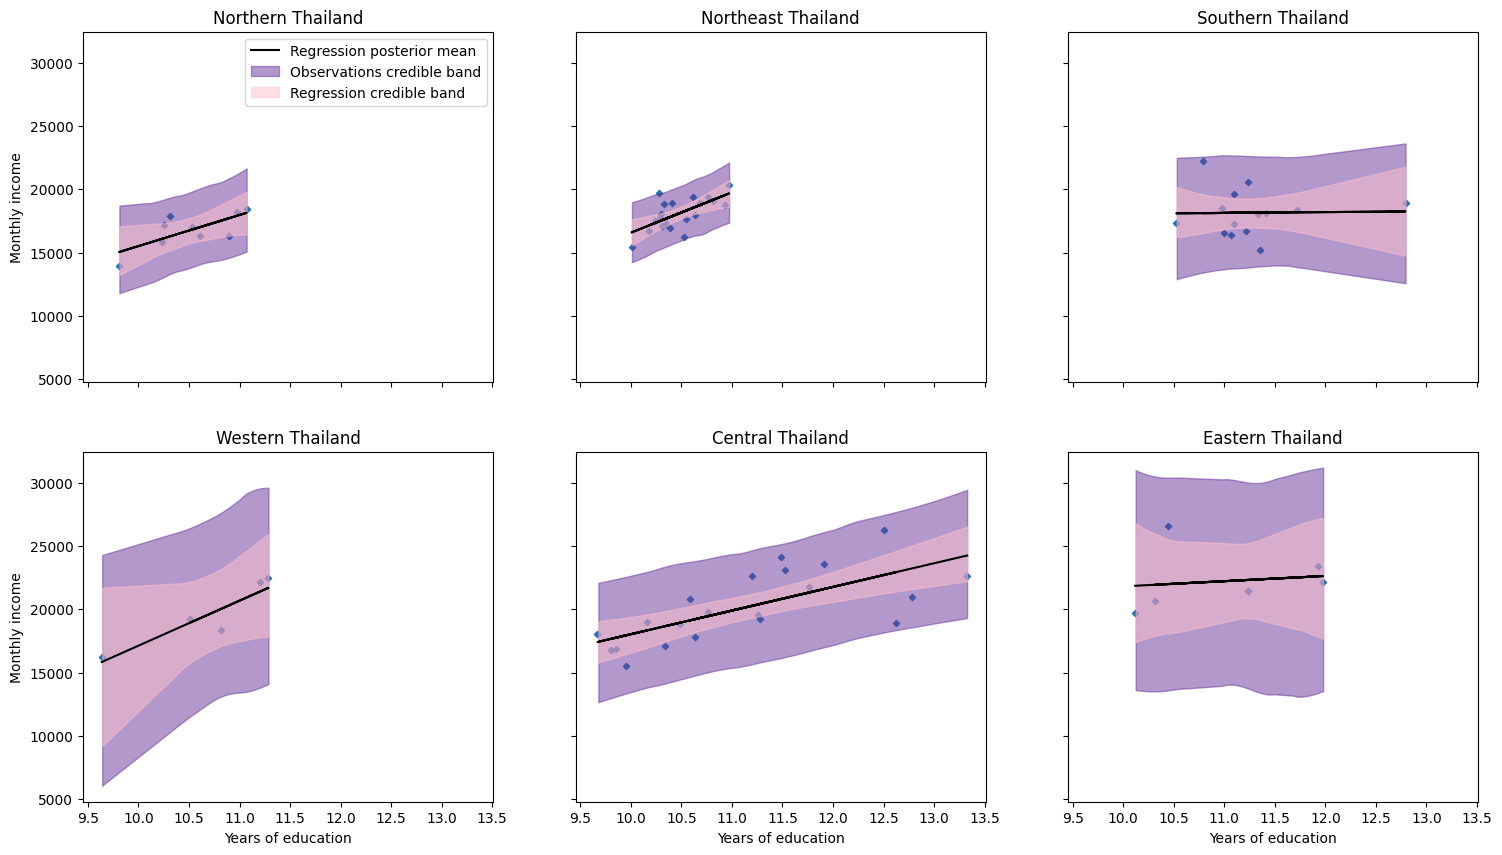

In [17]:
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(18,10))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = Dat[Dat['RegionNumber']==k]

    ax.scatter(
        Aux[PREDICTOR]
        , Aux[VARIABLE + 'Mean']
        , marker = 'D'
        , s = 10
    )

    ax.plot(
        Aux[PREDICTOR]
        , TraceSeparateAlphaSeparateBeta.posterior.MeanIncome[:,:,Aux.index].mean(('chain', 'draw'))
        , label="Regression posterior mean"
        , color='k'
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceSeparateAlphaSeparateBeta.posterior_predictive.Income[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='rebeccapurple'
        , fill_kwargs={'alpha': 0.5, 'label':"Observations credible band"}
        , ax = ax
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceSeparateAlphaSeparateBeta.posterior.MeanIncome[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='pink'
        , fill_kwargs={'alpha': 0.5, 'label':"Regression credible band"}
        , ax = ax
    )

    ax.set_title(NumbersToRegions[k])

    if k in [0,3]:
        ax.set_ylabel(VARIABLE2)
        
        if k == 0:
            ax.legend()

    if k in [3,4,5]:
        ax.set_xlabel(PREDICTOR2)